In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

In [2]:
## load the data

full_df = pd.read_pickle("2010_data.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME', 'geometry'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,4.351195e-06,4.876012e-09,3.973694e-06,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,2.916594e-06,25.766945,25.620820,2.109251e-06,4.289945e-06,3.297524e-06,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,1.620365e-06
1,77.826608,286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,3.513297e-06,4.926652e-09,2.062545e-06,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,2.408668e-06,27.838995,27.701486,2.641386e-06,5.453165e-06,4.363785e-06,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,1.140217e-06
2,75.841973,284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,4.161191e-06,4.878442e-09,3.484876e-06,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,2.561723e-06,26.076443,25.936913,2.072566e-06,4.220296e-06,3.329836e-06,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,1.212712e-06
3,73.705432,283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,4.369584e-06,4.879895e-09,3.844808e-06,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,3.263775e-06,25.607194,25.458810,2.049331e-06,4.173433e-06,3.204589e-06,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,1.971961e-06
4,75.753407,282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,4.043741e-06,4.893173e-09,2.631260e-06,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,3.696579e-06,24.042930,23.889293,1.644247e-06,3.319324e-06,2.564080e-06,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,2.447597e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.842111,278.301219,0.004760,0.01800,0.004101,2.370862,0.499930,101630.449624,0.043633,7.253336e-09,1.103061e-08,0.005092,0.798388,288.873684,0.016426,0.023886,78530.596578,268.911264,0.081471,0.000644,0.000003,1.057299e-06,4.941603e-09,8.047194e-08,0.007655,0.000003,0.000002,4.937694e-07,0.006915,0.000005,5.093373e-07,1.734801e-06,7.928388,7.855770,5.407217e-07,1.250976e-06,3.762784e-06,9.304454e-08,0.000002,4.126463e-07,0.000008,2.043045e-07,0.000013,9.202822e-07,0.000003,1.312529e-06
3123,83.771012,267.887551,274.410086,0.004909,0.01800,0.001664,2.481296,2.428177,101634.772736,0.046080,6.861324e-09,9.790676e-09,0.006100,0.807739,305.402204,0.095034,0.021758,75497.845779,268.751272,0.080511,0.000615,0.000003,8.352510e-07,4.851321e-09,7.964809e-08,0.007339,0.000003,0.000001,2.701267e-07,0.007030,0.000004,4.969263e-07,5.508047e-07,6.659885,6.563536,2.826886e-07,6.105456e

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.53


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()


In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')


RMSE scores for each fold: [1.45212937 1.42292227 1.52831291 1.3860143 ]
Mean RMSE score: 1.4473447104571042
Standard deviation of RMSE scores: 0.052289144072619136


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'n_estimators':[80,90,100,110,120,150], 'max_features': [6,8,10,12,15], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 270 candidates, totalling 1080 fits
CPU times: total: 34min 57s
Wall time: 6min 24s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [6, 8, 10, 12, 15],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [80, 90, 100, 110, 120, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=100, max_features=12, min_samples_split=5,
                      n_estimators=90, n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.65


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.64


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.42


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.93


In [14]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.62


In [15]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.92
The adjusted test r_sq ::: 0.58


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

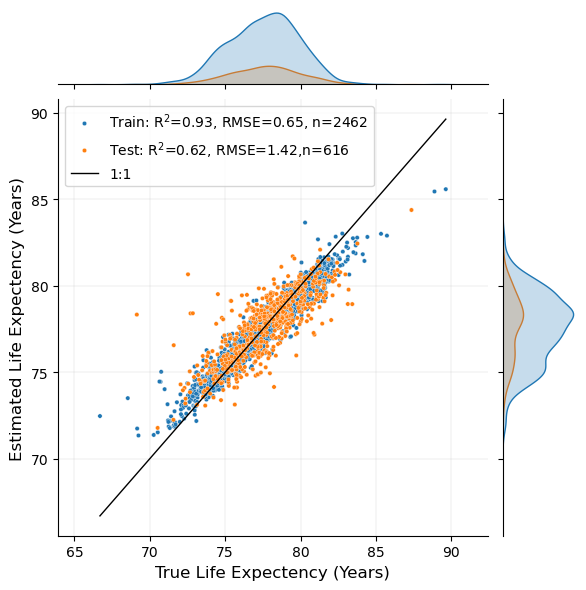

In [17]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  


g.ax_joint.legend(handles=handles,  labels=[ f'Train: R$^2$={corr_train}, RMSE={rmse_train}, n={len(X_train)}', 
                                             f'Test: R$^2$={corr_test}, RMSE={rmse_test},n={len(X_test)}','1:1'],
                                                                                                        title=None)

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

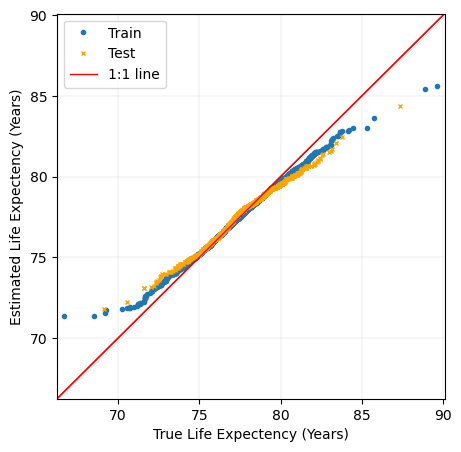

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

## Find feature importance on the train set

In [19]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
train_permutation

{'importances_mean': array([9.45202912e-02, 6.63724537e-02, 2.88337327e-02, 7.47269677e-03,
        6.03083091e-02, 3.69757968e-02, 5.33898513e-02, 1.77899556e-01,
        3.69920210e-02, 8.63506797e-17, 7.40148683e-17, 2.76617931e-02,
        3.39459771e-02, 3.88693090e-02, 2.92803515e-02, 6.70945556e-02,
        3.22938987e-02, 4.75621746e-02, 3.23199991e-02, 3.08850349e-02,
        8.43479666e-05, 1.46731622e-03, 7.40148683e-17, 8.40137450e-03,
        2.72383793e-02, 2.72675482e-03, 8.99639604e-03, 1.64636480e-04,
        4.88495638e-02, 3.39113186e-03, 2.45847657e-05, 5.27517945e-03,
        4.62407354e-02, 9.00134607e-02, 6.50311170e-04, 1.79909516e-03,
        6.25685488e-03, 5.49633403e-06, 1.45437199e-03, 8.67798227e-05,
        7.60423775e-03, 3.59080193e-05, 1.37076167e-02, 3.44042049e-03,
        3.83479015e-03, 4.33328930e-03]),
 'importances_std': array([3.12872423e-03, 2.23957457e-03, 9.29608250e-04, 3.21753388e-04,
        2.56458296e-03, 1.01400573e-03, 1.52321335e-03,

In [20]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [21]:
mean_val

array([9.45202912e-02, 6.63724537e-02, 2.88337327e-02, 7.47269677e-03,
       6.03083091e-02, 3.69757968e-02, 5.33898513e-02, 1.77899556e-01,
       3.69920210e-02, 8.63506797e-17, 7.40148683e-17, 2.76617931e-02,
       3.39459771e-02, 3.88693090e-02, 2.92803515e-02, 6.70945556e-02,
       3.22938987e-02, 4.75621746e-02, 3.23199991e-02, 3.08850349e-02,
       8.43479666e-05, 1.46731622e-03, 7.40148683e-17, 8.40137450e-03,
       2.72383793e-02, 2.72675482e-03, 8.99639604e-03, 1.64636480e-04,
       4.88495638e-02, 3.39113186e-03, 2.45847657e-05, 5.27517945e-03,
       4.62407354e-02, 9.00134607e-02, 6.50311170e-04, 1.79909516e-03,
       6.25685488e-03, 5.49633403e-06, 1.45437199e-03, 8.67798227e-05,
       7.60423775e-03, 3.59080193e-05, 1.37076167e-02, 3.44042049e-03,
       3.83479015e-03, 4.33328930e-03])

In [22]:
mean_importance

[(0.17789955562549956, 'msl'),
 (0.09452029121496751, 'd2m'),
 (0.09001346073096671, 'tcwv'),
 (0.06709455563285187, 'suaod550'),
 (0.06637245369928443, 't2m'),
 (0.060308309064463446, 'duaod550'),
 (0.053389851252347284, 'lai_lv'),
 (0.0488495637871211, 'gtco3'),
 (0.0475621745995056, 'tsn'),
 (0.046240735406795075, 'tcw'),
 (0.03886930903653983, 'rsn'),
 (0.03699202101076677, 'omaod550'),
 (0.0369757968470538, 'lai_hv'),
 (0.03394597713715297, 'asn'),
 (0.032319999113611685, 'aod550'),
 (0.03229389871920358, 'sp'),
 (0.030885034886805236, 'tcco'),
 (0.029280351517498835, 'sd'),
 (0.0288337327372367, 'bcaod550'),
 (0.027661793053837883, 'ssaod550'),
 (0.027238379288963038, 'tc_ch4'),
 (0.013707616730336047, 'aermssssm'),
 (0.00899639603693567, 'tcno2'),
 (0.008401374500100737, 'tc_c5h8'),
 (0.00760423774835892, 'aermssomhphob'),
 (0.0074726967659706454, 'chnk'),
 (0.006256854883677492, 'aermssdul'),
 (0.005275179445717488, 'tcso2'),
 (0.004333289295711775, 'aermssso2'),
 (0.0038347901

In [23]:
std_importance

[(0.004591233876291451, 'msl'),
 (0.003128724232065911, 'd2m'),
 (0.0025645829646099875, 'duaod550'),
 (0.002420340583977327, 'tcwv'),
 (0.0022395745747732744, 't2m'),
 (0.0018036289654632255, 'tsn'),
 (0.0016966901971664917, 'suaod550'),
 (0.0015232133494015932, 'lai_lv'),
 (0.0014121735026487545, 'gtco3'),
 (0.001375001416398142, 'sd'),
 (0.001268073877794155, 'sp'),
 (0.001155896892746286, 'tcw'),
 (0.001080737032541049, 'tc_ch4'),
 (0.0010206460274650964, 'ssaod550'),
 (0.0010140057275008691, 'lai_hv'),
 (0.0009296082501797665, 'bcaod550'),
 (0.0009072597715843512, 'aod550'),
 (0.0007459146869595173, 'tcco'),
 (0.0006259951043919684, 'asn'),
 (0.0006134392027899166, 'omaod550'),
 (0.0005982514889039969, 'rsn'),
 (0.000589064043906555, 'aermssssm'),
 (0.0005769873231570314, 'aermssomhphob'),
 (0.0005159642320740714, 'tc_c5h8'),
 (0.000418057536848043, 'tcno2'),
 (0.0003217533883884087, 'chnk'),
 (0.0002561530499384553, 'tcso2'),
 (0.0002462347238758302, 'aermssso2'),
 (0.00023607738

In [24]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

          Feature   Mean Weight  Standard Deviation
7             msl  1.778996e-01        4.591234e-03
0             d2m  9.452029e-02        3.128724e-03
33           tcwv  9.001346e-02        2.420341e-03
15       suaod550  6.709456e-02        1.696690e-03
1             t2m  6.637245e-02        2.239575e-03
4        duaod550  6.030831e-02        2.564583e-03
6          lai_lv  5.338985e-02        1.523213e-03
28          gtco3  4.884956e-02        1.412174e-03
17            tsn  4.756217e-02        1.803629e-03
32            tcw  4.624074e-02        1.155897e-03
13            rsn  3.886931e-02        5.982515e-04
8        omaod550  3.699202e-02        6.134392e-04
5          lai_hv  3.697580e-02        1.014006e-03
12            asn  3.394598e-02        6.259951e-04
18         aod550  3.232000e-02        9.072598e-04
16             sp  3.229390e-02        1.268074e-03
19           tcco  3.088503e-02        7.459147e-04
14             sd  2.928035e-02        1.375001e-03
2        bca

<Axes: xlabel='Mean Weight', ylabel='Feature'>

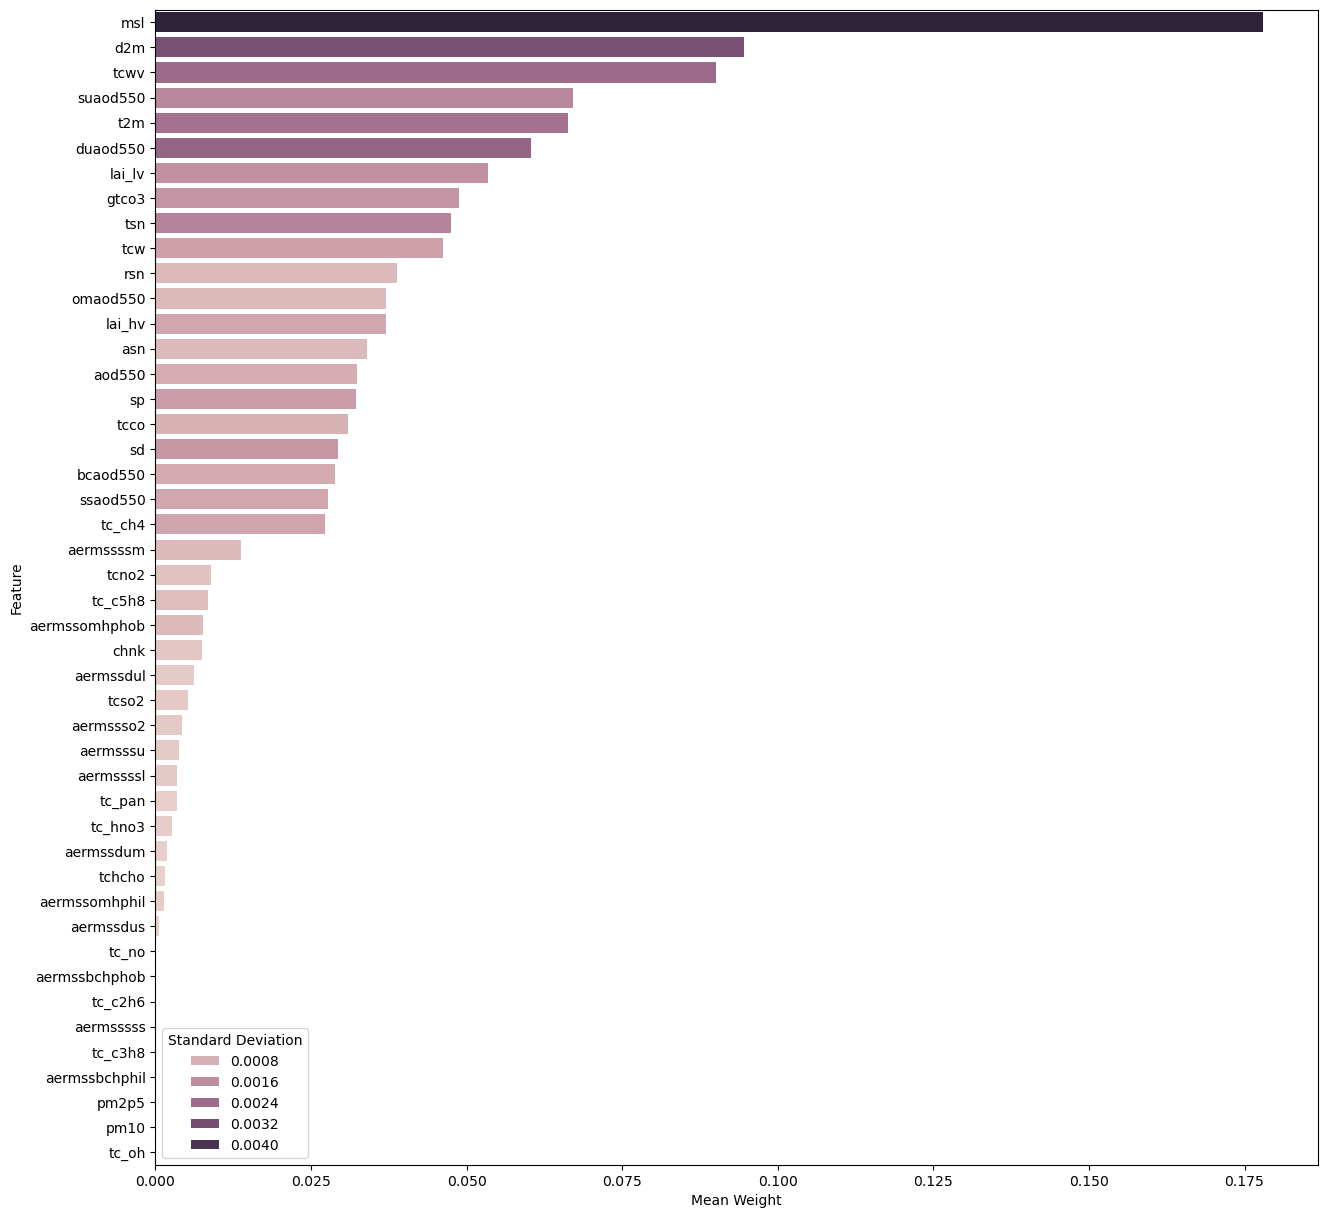

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find permutation importance in test set

In [26]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5


<Axes: xlabel='Mean Weight', ylabel='Feature'>

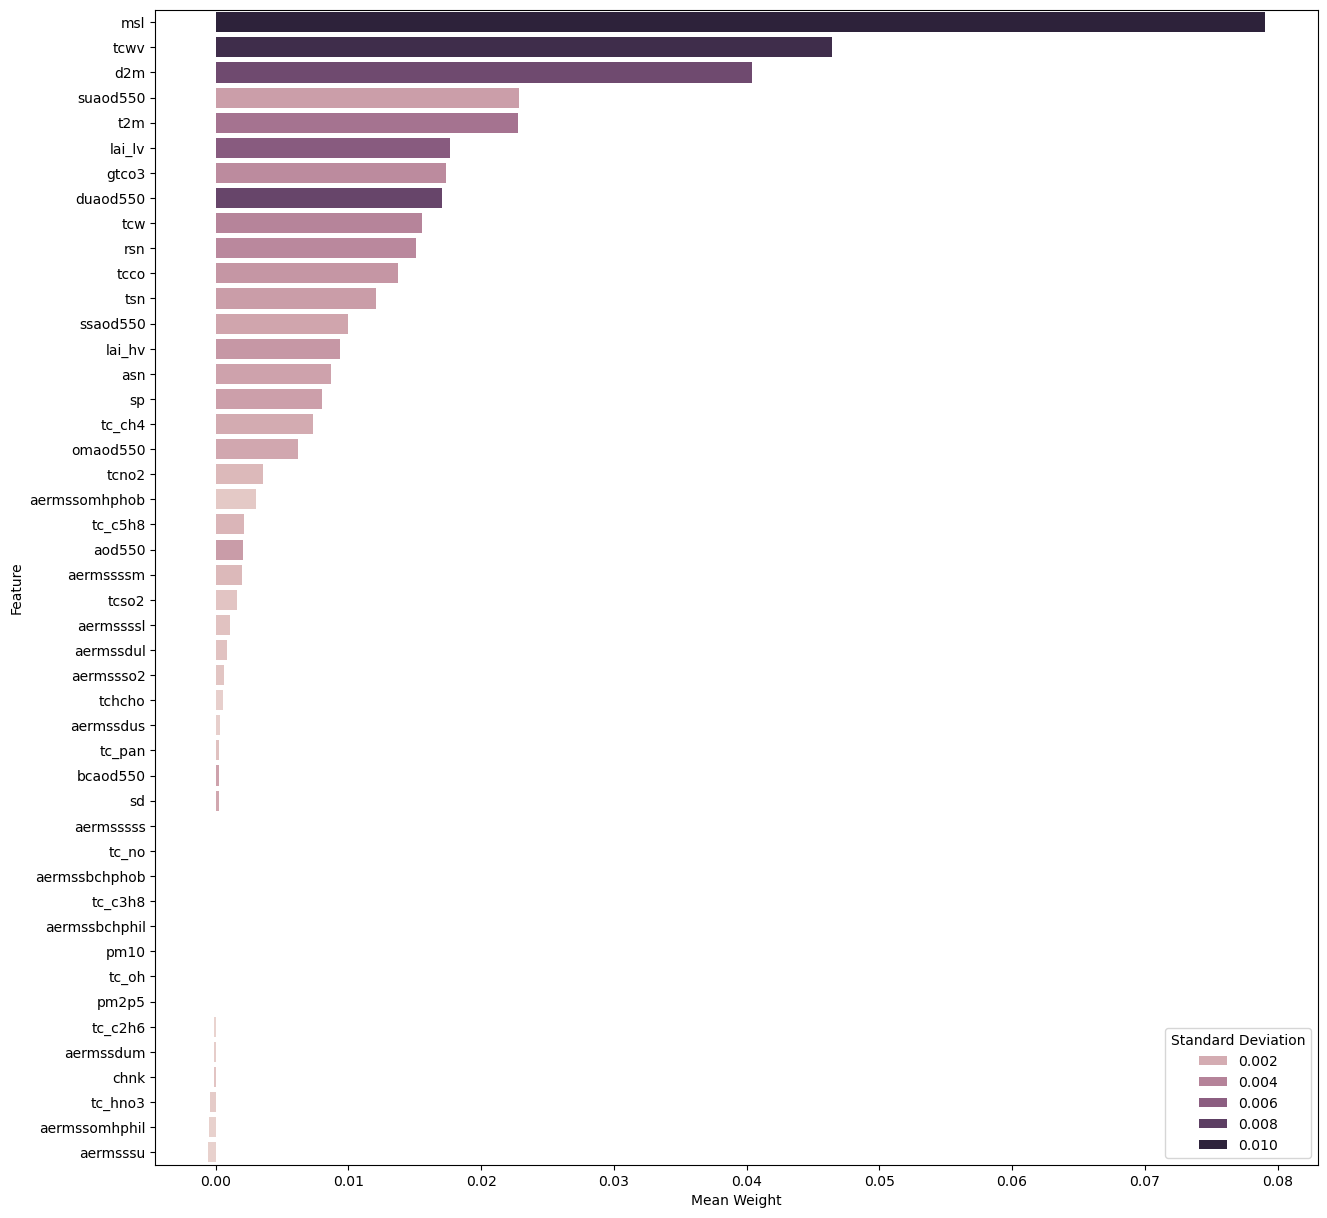

In [27]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find feature importance using SHAP
### This step is necessary because of the Warning sign here https://scikit-learn.org/1.5/modules/permutation_importance.html

In [28]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)


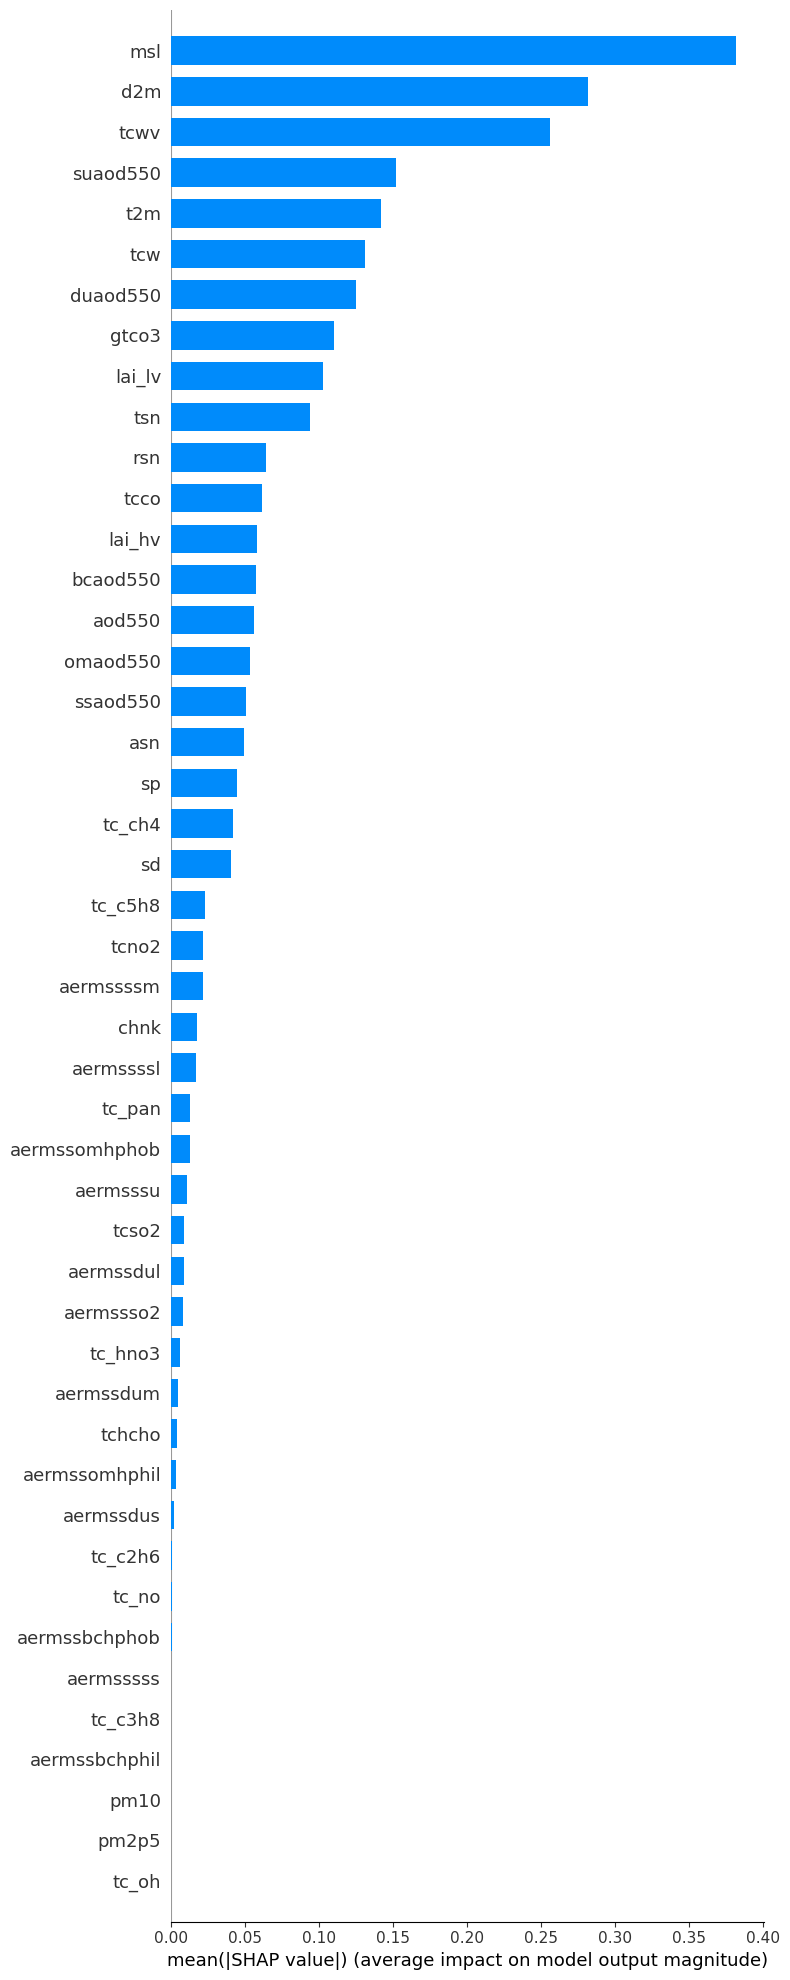

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

In [30]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

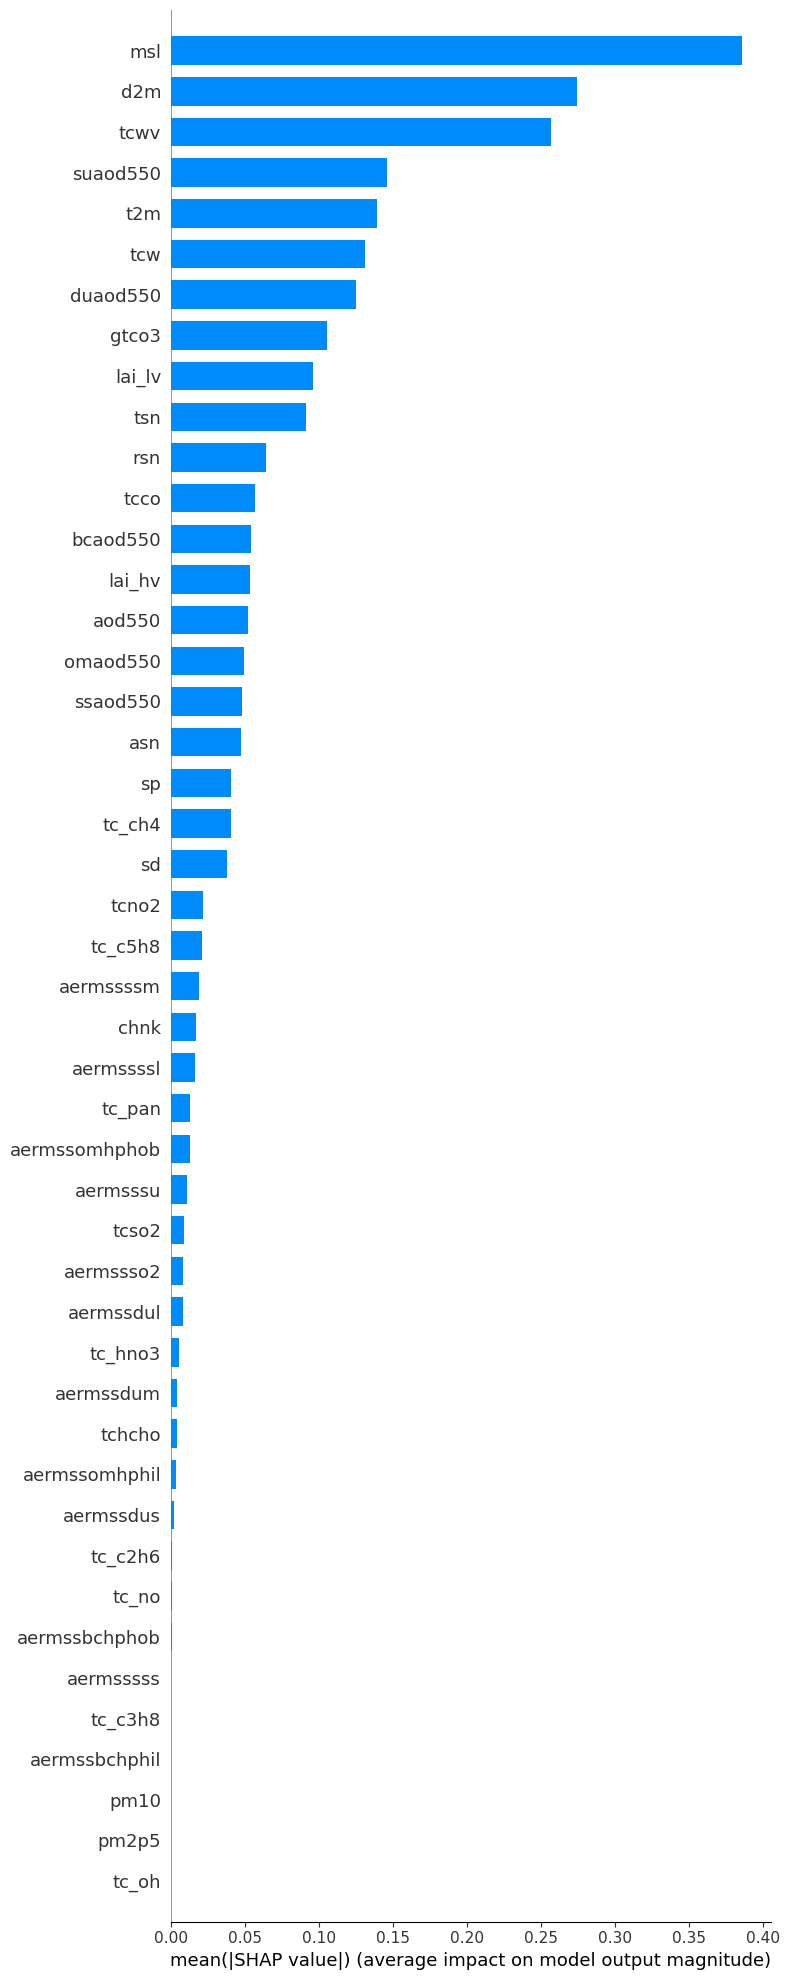

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

# Plot True Values on a map

In [32]:
##  load the county shapefile

SHAPE_PATH = os.path.join("County_shapefile",'gz_2010_us_050_00_500k.shp')
county_gdf = gpd.read_file(SHAPE_PATH)

county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [33]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum
## This step is necessary because there can be several counties with idential names. 

county_gdf['fips']=county_gdf['STATE'] + county_gdf['COUNTY']
county_gdf.dtypes
## convert the data type
county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041


In [34]:
full_df = pd.read_pickle("2010_data.pkl")
full_df.head(2)

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,0.000001,0.000008,0.000002
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,0.000002,0.000008,0.000001


In [35]:
true_LE = full_df[['fips', 'MeanLifeExpectency']]
type(true_LE)

pandas.core.frame.DataFrame

In [36]:
true_LE

,fips,MeanLifeExpectency
0,1001,75.728489
1,1003,77.826608
2,1005,75.841973
3,1007,73.705432
4,1009,75.753407
...,...,...
3122,56037,77.582422
3123,56039,83.771012
3124,56041,77.836526
3125,56043,78.674180


In [99]:
gpd_df = pd.merge(county_gdf, true_LE, on='fips', how='left') 
gpd_df= gpd_df.dropna()
gpd_df.head(2)
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374


In [100]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [101]:
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [102]:
## include only CONUS shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands', 'Puerto Rico' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [103]:
gpd_df

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.226496
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.987621
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.413447
...,...,...,...,...,...,...,...,...,...
3138,0500000US56027,56,027,Niobrara,County,2626.037,"POLYGON ((-104.05298 42.85955, -104.05286 42.7...",56027,78.569014
3139,0500000US56031,56,031,Platte,County,2084.208,"POLYGON ((-104.77417 42.60996, -104.76422 42.6...",56031,78.740940
3140,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037,77.582422
3141,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043,78.674180


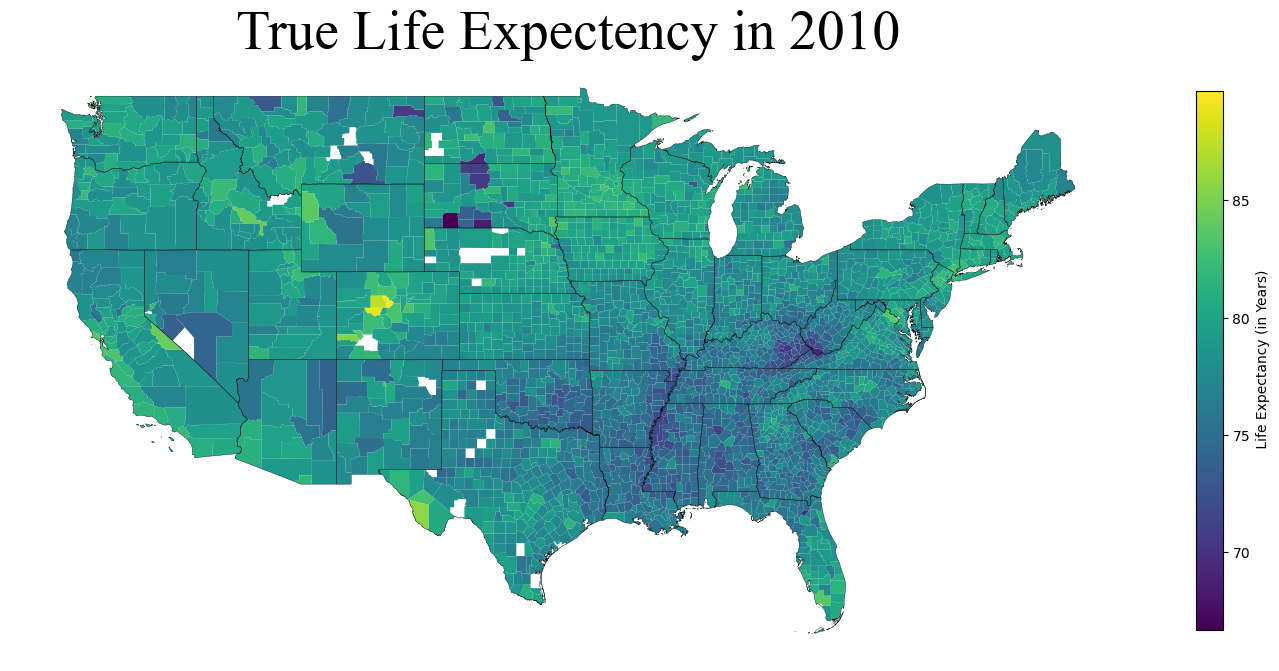

In [104]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50})
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('True Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Plot estimated life expectancy in train and test data

In [50]:
train_prediction

array([79.61073172, 78.50487533, 78.49987805, ..., 77.31666234,
       77.10393854, 76.53390319])

In [51]:
y_train

569     79.135049
3117    78.569014
1611    79.128676
2287    78.098212
1870    77.540108
          ...    
1174    75.395827
2873    79.703423
1528    77.303422
1935    77.109515
391     76.636106
Name: MeanLifeExpectency, Length: 2462, dtype: float64

In [52]:
y_train_df=pd.DataFrame([y_train]).T
y_train_df['Train Prediction']=train_prediction
y_train_df

,MeanLifeExpectency,Train Prediction
569,79.135049,79.610732
3117,78.569014,78.504875
1611,79.128676,78.499878
2287,78.098212,77.934067
1870,77.540108,78.049540
...,...,...
1174,75.395827,75.357429
2873,79.703423,79.513335
1528,77.303422,77.316662
1935,77.109515,77.103939


In [53]:
y_test_df=pd.DataFrame([y_test]).T
y_test_df
y_test_df['Test Prediction']=test_prediction
y_test_df

,MeanLifeExpectency,Test Prediction
3036,80.253803,79.312722
1908,76.558524,77.420812
2131,76.675288,78.111984
41,77.354925,75.945611
49,74.820993,74.418182
...,...,...
531,74.456873,75.130259
1074,77.006246,75.627209
131,76.787065,75.945140
468,77.281115,77.481524


In [54]:
y_train_df=y_train_df.drop('MeanLifeExpectency', axis=1)
y_test_df=y_test_df.drop('MeanLifeExpectency', axis=1)

In [116]:
df_train = pd.merge(full_df, ## merge index with original data
                    y_train_df, left_index=True, right_index=True, how='left') 
df_train.head()

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Train Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,0.000002,NaN
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,0.000001,77.121031
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,0.000004,4.878442e-09,0.000003,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,0.000003,26.076443,25.936913,0.000002,0.000004,0.000003,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,0.000001,75.656341
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,"POLYGON ((-87.11632 32.83560, -87.15529 32.835...",283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,0.000004,4.879895e-09,0.000004,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,0.000003,25.607194,25.458810,0.000002,0.000004,0.000003,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,0.000002,74.054662
4,Blount County (Alabama),1009,2010,75.753407,Blount,"POLYGON ((-86.73121 34.01470, -86.72710 34.016...",282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,0.000004,4.893173e-09,0.000003,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,0.000004,24.042930,23.889293,0.000002,0.000003,0.000003,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,0.000002,75.143832


In [118]:
df_train = df_train[['fips', 'Train Prediction']]
df_train=df_train.dropna()
df_train

,fips,Train Prediction
1,1003,77.121031
2,1005,75.656341
3,1007,74.054662
4,1009,75.143832
5,1011,74.695410
...,...,...
3120,56033,78.254043
3121,56035,81.387444
3124,56041,78.768448
3125,56043,78.266855


In [121]:
plot_train = pd.merge(county_gdf, df_train, on='fips', how='left') 
plot_train= plot_train.dropna()
plot_train.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Train Prediction
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.162496
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.130960
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.674959
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.862508
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.760342


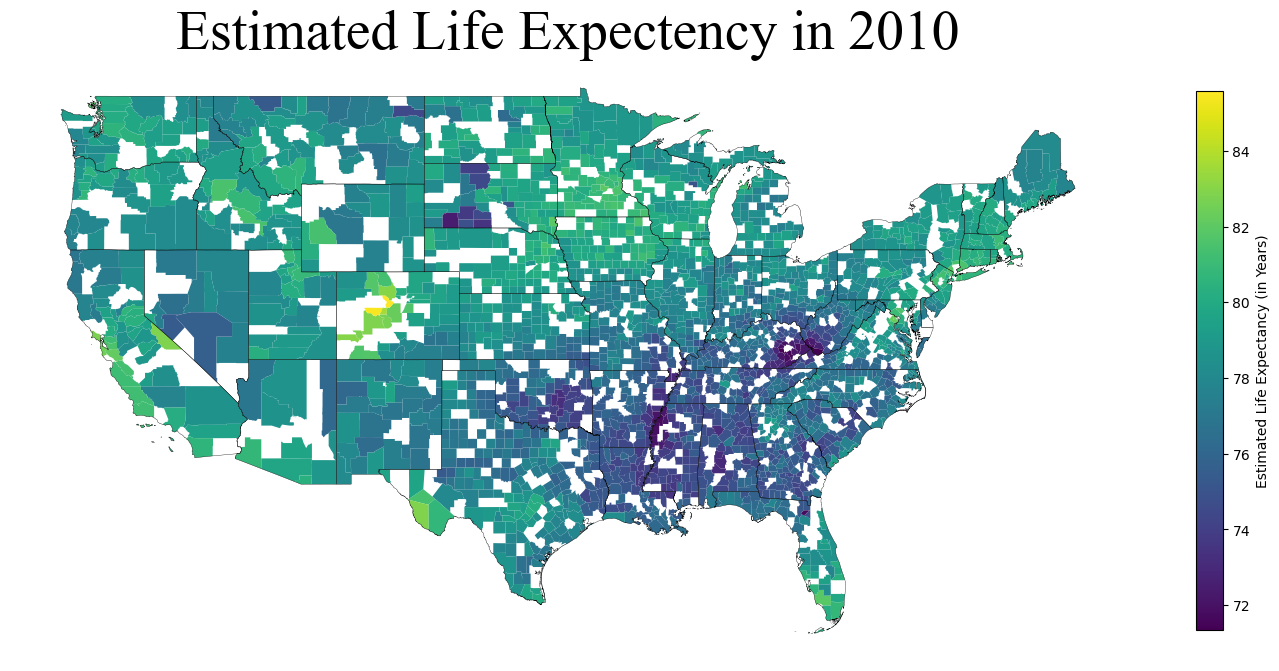

In [122]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_train.plot(ax=ax,column='Train Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years) (Train set) ", 
                                                                                   "shrink":0.50})
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

In [125]:
df_test = pd.merge(full_df, ## merge index with original data
                    y_test_df, left_index=True, right_index=True, how='left') 
df_test.head()

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Test Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,0.000002,74.763179
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,0.000001,NaN
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,0.000004,4.878442e-09,0.000003,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,0.000003,26.076443,25.936913,0.000002,0.000004,0.000003,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,0.000001,NaN
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,"POLYGON ((-87.11632 32.83560, -87.15529 32.835...",283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,0.000004,4.879895e-09,0.000004,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,0.000003,25.607194,25.458810,0.000002,0.000004,0.000003,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,0.000002,NaN
4,Blount County (Alabama),1009,2010,75.753407,Blount,"POLYGON ((-86.73121 34.01470, -86.72710 34.016...",282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,0.000004,4.893173e-09,0.000003,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,0.000004,24.042930,23.889293,0.000002,0.000003,0.000003,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,0.000002,NaN


In [126]:
df_test = df_test[['fips', 'Test Prediction']]
df_test=df_test.dropna()
df_test

,fips,Test Prediction
0,1001,74.763179
25,1051,74.713294
31,1063,73.968181
32,1065,73.756248
41,1083,75.945611
...,...,...
3111,56015,78.860215
3116,56025,78.146441
3118,56029,78.472705
3122,56037,78.581964


In [127]:
plot_test = pd.merge(county_gdf, df_test, on='fips', how='left') 
plot_test= plot_test.dropna()
plot_test.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Test Prediction
14,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",1001,74.763179
27,0500000US01051,01,051,Elmore,County,618.485,"POLYGON ((-86.31945 32.75621, -86.31948 32.753...",1051,74.713294
30,0500000US01063,01,063,Greene,County,647.110,"POLYGON ((-87.87038 32.76262, -87.86884 32.760...",1063,73.968181
31,0500000US01065,01,065,Hale,County,643.943,"POLYGON ((-87.43736 32.83078, -87.45166 32.830...",1065,73.756248
34,0500000US01085,01,085,Lowndes,County,715.911,"POLYGON ((-86.81080 32.30757, -86.79827 32.308...",1085,73.841771


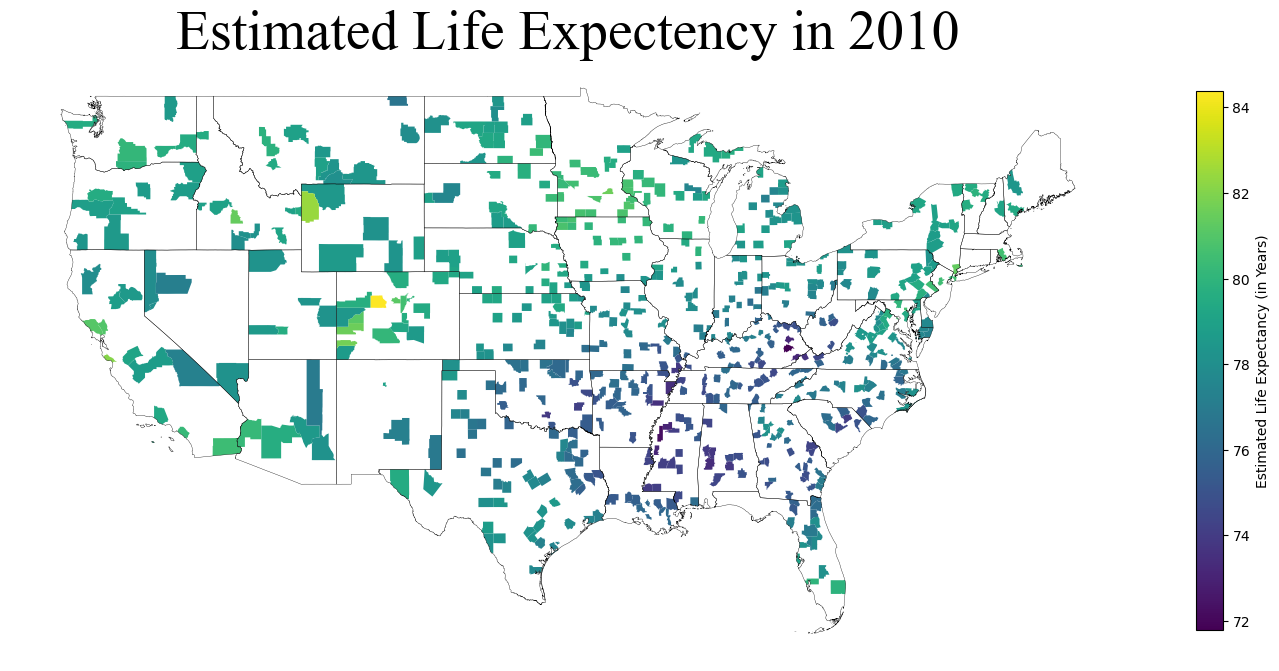

In [129]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_test.plot(ax=ax,column='Test Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years) (Test set)", 
                                                                                   "shrink":0.50})
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

In [109]:
df_test = pd.merge(gpd_df, y_test_df, left_index=True, right_index=True, how='left') 
df_test=df_test.dropna()
df_test

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency,Test Prediction
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806,74.763179
25,0500000US01043,01,043,Cullman,County,734.841,"POLYGON ((-86.90118 34.30972, -86.89937 34.309...",1043,75.061513,74.713294
31,0500000US01065,01,065,Hale,County,643.943,"POLYGON ((-87.43736 32.83078, -87.45166 32.830...",1065,73.996618,73.968181
32,0500000US01071,01,071,Jackson,County,1077.868,"MULTIPOLYGON (((-86.14989 34.53363, -86.14981 ...",1071,74.056304,73.756248
41,0500000US01107,01,107,Pickens,County,881.408,"POLYGON ((-88.29710 33.34909, -88.29589 33.359...",1107,74.435773,75.945611
...,...,...,...,...,...,...,...,...,...,...
3111,0500000US55105,55,105,Rock,County,718.142,"POLYGON ((-89.07076 42.49621, -89.07114 42.496...",55105,78.485343,78.860215
3116,0500000US55133,55,133,Waukesha,County,549.574,"POLYGON ((-88.06959 42.89849, -88.06959 42.898...",55133,81.380011,78.146441
3118,0500000US55139,55,139,Winnebago,County,434.487,"POLYGON ((-88.41965 44.24405, -88.41727 44.244...",55139,79.906278,78.472705
3122,0500000US56003,56,003,Big Horn,County,3137.097,"POLYGON ((-108.62131 45.00041, -108.57848 45.0...",56003,76.885161,78.581964


In [111]:
df_train=df_train.dropna()
df_test= df_test.dropna()
df_train=df_train.rename(columns={"Train Prediction": "Estimated"})
df_test=df_test.rename(columns={"Test Prediction": "Estimated"})

In [112]:
final_df=pd.concat([df_train, df_test])
final_df

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency,Estimated
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374,77.121031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.226496,75.656341
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.987621,74.054662
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.413447,75.143832
5,0500000US01045,01,045,Dale,County,561.150,"POLYGON ((-85.79043 31.32027, -85.79033 31.323...",1045,76.377633,74.695410
...,...,...,...,...,...,...,...,...,...,...
3111,0500000US55105,55,105,Rock,County,718.142,"POLYGON ((-89.07076 42.49621, -89.07114 42.496...",55105,78.485343,78.860215
3116,0500000US55133,55,133,Waukesha,County,549.574,"POLYGON ((-88.06959 42.89849, -88.06959 42.898...",55133,81.380011,78.146441
3118,0500000US55139,55,139,Winnebago,County,434.487,"POLYGON ((-88.41965 44.24405, -88.41727 44.244...",55139,79.906278,78.472705
3122,0500000US56003,56,003,Big Horn,County,3137.097,"POLYGON ((-108.62131 45.00041, -108.57848 45.0...",56003,76.885161,78.581964


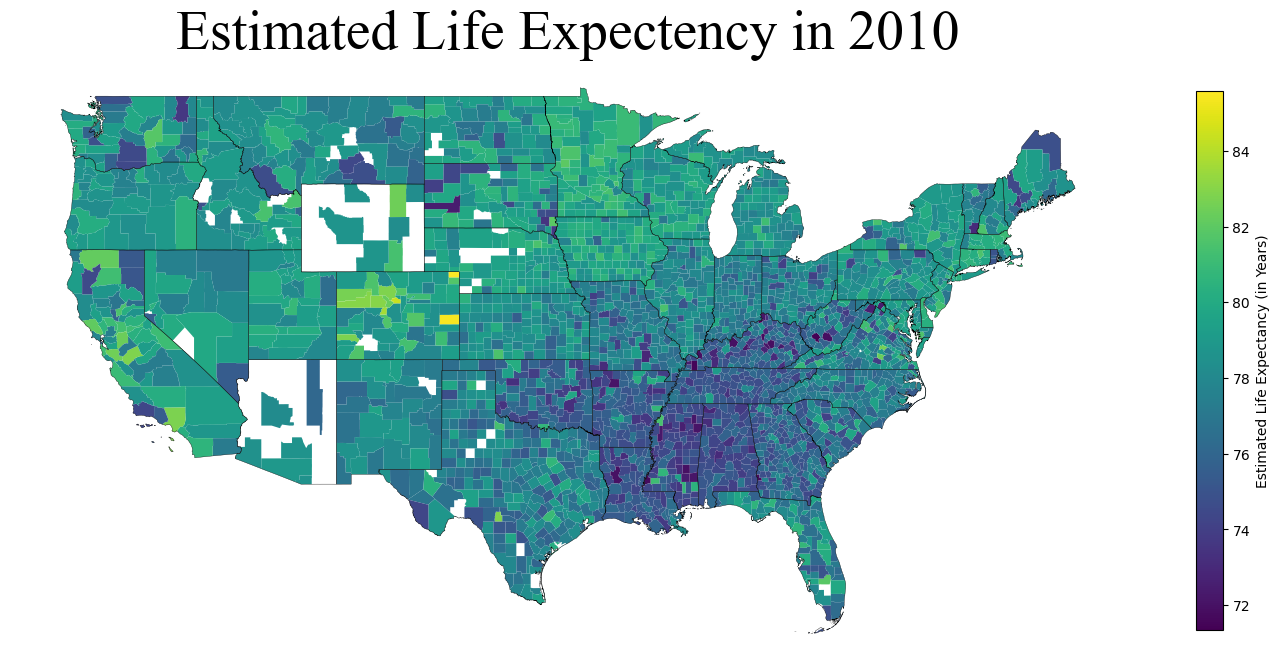

In [113]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
final_df.plot(ax=ax,column='Estimated', legend=True, legend_kwds={"label": "Estimated Life Expectancy (in Years)", 
                                                                                   "shrink":0.50})
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()